
А) обучить классификаторы на
1) сырые
2) лемматизированные
3) rake

B) Материалы:
1) новости
2) отзывы

In [1]:
import os
import re
import pymorphy2
import pandas as pd
from rake_nltk import Rake
from sklearn import metrics
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

In [2]:
def show_cm(target_test, predicted):
    cm =  metrics.confusion_matrix(target_test, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

    cm_display.plot()
    plt.show()

In [3]:
def process_corpus(dir_path: str, eval: str):
    results = []
    morph = pymorphy2.MorphAnalyzer()
    r_model = Rake(language='russian')
    for item in os.listdir(dir_path):
        path = dir_path + '/' + item
        if os.path.isfile(path):
            with open(path, encoding='utf-8') as f:
                text = f.read()
                text = re.split('<\d+>', text)
                for instance in text:
                    words = instance.split(' ')
                    lemmatized_text = [morph.parse(word)[0].normal_form for word in words]
                    lemmatized_text = ' '.join(lemmatized_text)
                    r_model.extract_keywords_from_text(instance)
                    raked_text = ' '.join(r_model.get_ranked_phrases())
                    results.append((instance, lemmatized_text, raked_text, eval))
    return results

In [4]:
def get_data_news(rel_path: str):
    path = os.path.abspath('') + rel_path
    for item in os.listdir(path):
        item_path = path + '/' + item
        if os.path.isdir(item_path):
            results = process_corpus(item_path, item)
            df = pd.DataFrame(results)
            df.to_csv('news_processed.csv', mode='a', index=False, header=False)

In [5]:
get_data_news('/corpus_news')


In [6]:
df = pd.read_csv('news_processed.csv', names=['Raw', 'Lemmatized', 'Rake', 'Evaluation'])

df.head(-10)

,Raw,Lemmatized,Rake,Evaluation
0,Посещение храма Василия Блаженного могут огран...,посещение храм василий блаженный мочь ограничи...,посещение храма василия блаженного могут огран...,culture
1,"Александр Серов назвал Афину идиоткой, дочь св...","александр серов назвать афина идиоткой, дочь с...",время программы произошло сразу несколько непр...,culture
2,"Тарантино сожалеет о ДТП, но душил цепью Уму Т...","тарантино сожалеть о дтп, но душить цепь ум ту...",интервью изданию vulture тарантино признался д...,culture
3,Подарок на 146 лет: 9 и 10 февраля вход в Исто...,подарок на 146 лет: 9 и 10 февраль вход в исто...,экспозиции музея отечественной войны 1812 года...,culture
4,Российским артистам предложили гастролировать ...,российский артист предложить гастролировать на...,железных клетках дмитрий корчинский — известны...,culture
...,...,...,...,...
8206,"Самые древние ""мелки"" окрасили историю первобы...","самый древний ""мелки"" окрасить история первобы...",руки археологов недавно попали самые древние о...,science
8207,На Большом адронном коллайдере обнаружена част...,на большой адронный коллайдер обнаружить части...,большом адронном коллайдере физики заставляли ...,science
8208,Долгожданный скелет рассказывает о туманной ис...,долгожданный скелет рассказывать о туманный ис...,"mansourasaurus shahinae ), впервые раскрывает ...",science
8209,"На орбиту выведена ""звезда человечества"", кото...","на орбита вывести ""звезда человечества"", котор...",объектов ночного неба частная компания rocket ...,science


In [9]:
evals = df['Evaluation']

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

raw_text = df['Raw']
lemmatized_text = df['Lemmatized']
raked_text = df['Rake']
evals = df['Evaluation']

raw_train, raw_test, raw_target_train, raw_target_test = train_test_split(raw_text, evals, train_size=0.5, random_state=45)
lemmatized_train, lemmatized_test, lemmatized_target_train, lemmatized_target_test = train_test_split(lemmatized_text, evals, train_size=0.5, random_state=45)
raked_train, raked_test, raked_target_train, raked_target_test = train_test_split(raked_text, evals, train_size=0.5, random_state=45)

print(raw_train)

7951    Небензя: у США к Ирану отношение, как у сенато...
2493    ASUS на MWC2018: Zenfone 5 в стиле iPhone X и ...
1902    Физики впервые создали суперионный лёд \n Амер...
7465    Собчак предложила провести праймериз среди либ...
6728    LTE оказался "дырявым": подмена местоположения...
                              ...                        
3704    Агитационный поезд: кандидаты спешат улучшить ...
163     Ажиотаж, ставший традиционным\n Московская фил...
6012    Депутат Саблин: ПЗРК, сбивший Су-25, завезли в...
6558    Мединского озаботили "Пятьдесят оттенков свобо...
7115    На MWC показали первый по-настоящему безрамочн...
Name: Raw, Length: 4110, dtype: object


Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfdif', TfidfTransformer()),
                     ('clf', LogisticRegression())])

text_clf.fit(raw_train, raw_target_train)

logreg_predicted = text_clf.predict(raw_test)


text_clf.fit(lemmatized_train, lemmatized_target_train)

logreg_predicted = text_clf.predict(lemmatized_test)



text_clf.fit(raked_train, raked_target_train)

logreg_predicted = text_clf.predict(raked_test)

print(metrics.classification_report(raw_target_test, logreg_predicted))
print(metrics.classification_report(lemmatized_target_test, logreg_predicted))
print(metrics.classification_report(raked_target_test, logreg_predicted))

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.00      1.00      1.00       955
    politics       1.00      1.00      1.00      1743
     science       1.00      0.99      1.00       718

    accuracy                           1.00      4111
   macro avg       1.00      1.00      1.00      4111
weighted avg       1.00      1.00      1.00      4111

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.00      1.00      1.00       955
    politics       1.00      1.00      1.00      1743
     science       1.00      0.99      1.00       718

    accuracy                           1.00      4111
   macro avg       1.00      1.00      1.00      4111
weighted avg       1.00      1.00      1.00      4111

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.

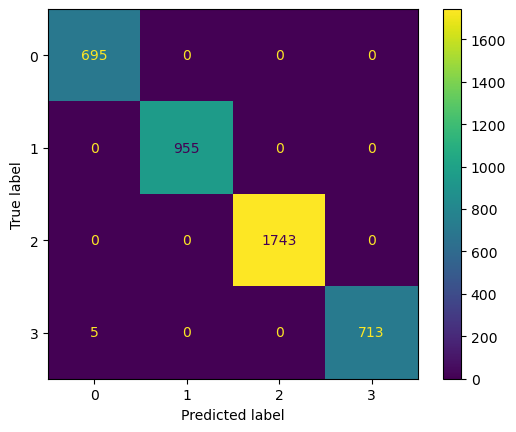

In [24]:
show_cm(raw_target_test, logreg_predicted)

Naive Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfdif', TfidfTransformer()),
                     ('clf', MultinomialNB())])

text_clf.fit(raw_train, raw_target_train)

mnb_predicted = text_clf.predict(raw_test)

print(metrics.classification_report(raw_target_test, mnb_predicted))


text_clf.fit(lemmatized_train, lemmatized_target_train)

mnb_predicted = text_clf.predict(lemmatized_test)

print(metrics.classification_report(lemmatized_target_test, mnb_predicted))


text_clf.fit(raked_train, raked_target_train)

mnb_predicted = text_clf.predict(raked_test)

print(metrics.classification_report(raked_target_test, mnb_predicted))

              precision    recall  f1-score   support

     culture       1.00      0.92      0.96       695
     hi-tech       1.00      1.00      1.00       955
    politics       0.97      1.00      0.98      1743
     science       0.99      0.98      0.99       718

    accuracy                           0.98      4111
   macro avg       0.99      0.98      0.98      4111
weighted avg       0.98      0.98      0.98      4111

              precision    recall  f1-score   support

     culture       1.00      0.89      0.94       695
     hi-tech       1.00      0.99      1.00       955
    politics       0.96      1.00      0.98      1743
     science       0.98      0.98      0.98       718

    accuracy                           0.98      4111
   macro avg       0.98      0.97      0.97      4111
weighted avg       0.98      0.98      0.98      4111

              precision    recall  f1-score   support

     culture       1.00      0.93      0.96       695
     hi-tech       1.

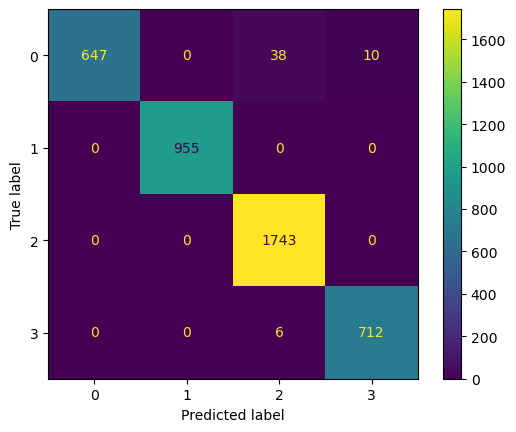

In [23]:
show_cm(raked_target_test, mnb_predicted)

Decision tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfdif', TfidfTransformer()),
                     ('clf', DecisionTreeClassifier())])

text_clf.fit(raw_train, raw_target_train)

dtc_predicted = text_clf.predict(raw_test)

print(metrics.classification_report(raw_target_test, dtc_predicted))


text_clf.fit(lemmatized_train, lemmatized_target_train)

dtc_predicted = text_clf.predict(lemmatized_test)

print(metrics.classification_report(lemmatized_target_test, dtc_predicted))


text_clf.fit(raked_train, raked_target_train)

dtc_predicted = text_clf.predict(raked_test)

print(metrics.classification_report(raked_target_test, dtc_predicted))

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.00      1.00      1.00       955
    politics       1.00      1.00      1.00      1743
     science       1.00      0.99      1.00       718

    accuracy                           1.00      4111
   macro avg       1.00      1.00      1.00      4111
weighted avg       1.00      1.00      1.00      4111

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.00      1.00      1.00       955
    politics       1.00      1.00      1.00      1743
     science       1.00      0.99      1.00       718

    accuracy                           1.00      4111
   macro avg       1.00      1.00      1.00      4111
weighted avg       1.00      1.00      1.00      4111

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.

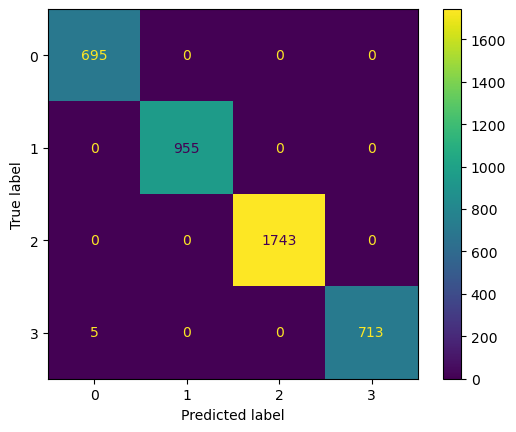

In [22]:
show_cm(raw_target_test, dtc_predicted)

Random Forests

In [14]:
from sklearn.ensemble import RandomForestClassifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfdif', TfidfTransformer()),
                     ('clf', RandomForestClassifier())])

text_clf.fit(raw_train, raw_target_train)

rfc_predicted = text_clf.predict(raw_test)

print(metrics.classification_report(raw_target_test, rfc_predicted))


text_clf.fit(lemmatized_train, lemmatized_target_train)

rfc_predicted = text_clf.predict(lemmatized_test)

print(metrics.classification_report(lemmatized_target_test, rfc_predicted))

text_clf.fit(raked_train, raked_target_train)

rfc_predicted = text_clf.predict(raked_test)

print(metrics.classification_report(raked_target_test, rfc_predicted))

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.00      1.00      1.00       955
    politics       1.00      1.00      1.00      1743
     science       1.00      0.99      1.00       718

    accuracy                           1.00      4111
   macro avg       1.00      1.00      1.00      4111
weighted avg       1.00      1.00      1.00      4111

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.00      1.00      1.00       955
    politics       1.00      1.00      1.00      1743
     science       1.00      0.99      1.00       718

    accuracy                           1.00      4111
   macro avg       1.00      1.00      1.00      4111
weighted avg       1.00      1.00      1.00      4111

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.

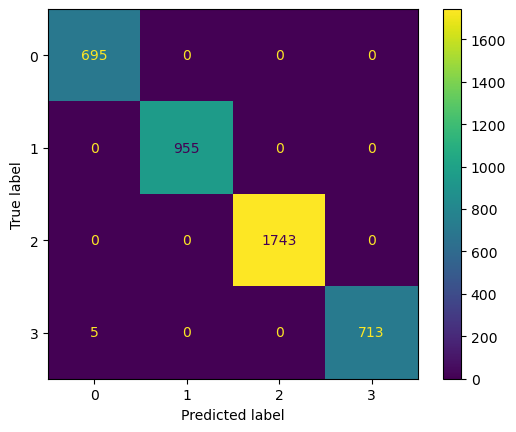

In [21]:
show_cm(lemmatized_target_test, rfc_predicted)

Support Vector Machines 

In [15]:
from sklearn.svm import LinearSVC

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfdif', TfidfTransformer()),
                     ('clf', LinearSVC())])

text_clf.fit(raw_train, raw_target_train)

lsvc_predicted = text_clf.predict(raw_test)

print(metrics.classification_report(raw_target_test, lsvc_predicted))



text_clf.fit(lemmatized_train, lemmatized_target_train)

lsvc_predicted = text_clf.predict(lemmatized_test)

print(metrics.classification_report(lemmatized_target_test, lsvc_predicted))


text_clf.fit(raked_train, raked_target_train)

lsvc_predicted = text_clf.predict(raked_test)

print(metrics.classification_report(raked_target_test, lsvc_predicted))

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.00      1.00      1.00       955
    politics       1.00      1.00      1.00      1743
     science       1.00      0.99      1.00       718

    accuracy                           1.00      4111
   macro avg       1.00      1.00      1.00      4111
weighted avg       1.00      1.00      1.00      4111

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.00      1.00      1.00       955
    politics       1.00      1.00      1.00      1743
     science       1.00      0.99      1.00       718

    accuracy                           1.00      4111
   macro avg       1.00      1.00      1.00      4111
weighted avg       1.00      1.00      1.00      4111

              precision    recall  f1-score   support

     culture       0.99      1.00      1.00       695
     hi-tech       1.

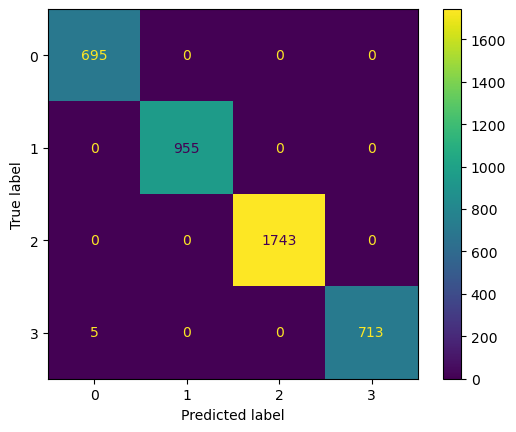

In [17]:
show_cm(raw_target_test, lsvc_predicted)

Алгоритм Роккио

In [16]:
from sklearn.neighbors import NearestCentroid

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfdif', TfidfTransformer()),
                     ('clf', NearestCentroid())])

text_clf.fit(raw_train, raw_target_train)

nc_predicted = text_clf.predict(raw_test)

print(metrics.classification_report(raw_target_test, nc_predicted))

text_clf.fit(lemmatized_train, lemmatized_target_train)

nc_predicted = text_clf.predict(lemmatized_test)

print(metrics.classification_report(lemmatized_target_test, nc_predicted))

text_clf.fit(raked_train, raked_target_train)

nc_predicted = text_clf.predict(raked_test)

print(metrics.classification_report(raked_target_test, nc_predicted))

              precision    recall  f1-score   support

     culture       0.94      0.99      0.96       695
     hi-tech       0.98      0.99      0.98       955
    politics       0.99      1.00      0.99      1743
     science       0.98      0.92      0.95       718

    accuracy                           0.98      4111
   macro avg       0.97      0.97      0.97      4111
weighted avg       0.98      0.98      0.98      4111

              precision    recall  f1-score   support

     culture       0.95      0.98      0.97       695
     hi-tech       0.98      0.98      0.98       955
    politics       0.99      0.99      0.99      1743
     science       0.96      0.94      0.95       718

    accuracy                           0.98      4111
   macro avg       0.97      0.97      0.97      4111
weighted avg       0.98      0.98      0.98      4111

              precision    recall  f1-score   support

     culture       0.96      0.99      0.97       695
     hi-tech       0.

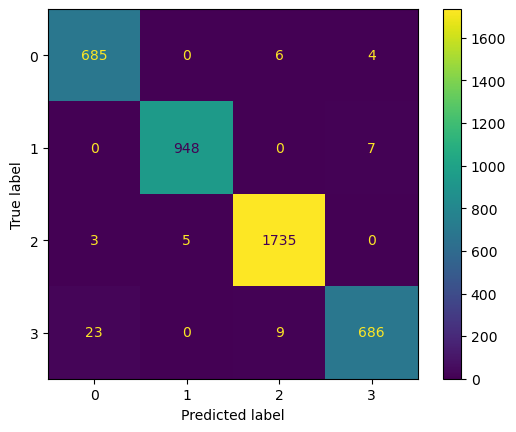

In [20]:
show_cm(raked_target_test, nc_predicted)